# Descenso por Gradiente y Regresión Logística

## 1. Descenso por Gradiente

### 1.1 Funciones de costo

Vamos a ver el concepto de función de costo para una regresión lineal. Recordemos que una función lineal tiene la forma $y = mx + b$, donde $m$ es la pendiente y $b$ es la ordenada al origen.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os #esta libreria permite trabajar con funciones del sistema operativo 
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


Generamos datos con ruido alrededor de una recta de la forma $y = 2x - 3$

In [2]:
x = np.linspace(-1,1,100)
m_0 = 2 # el verdadero valor de la pendiente
b_0 = -3 # el verdadero valor de la ordenada al origen
y = m_0*x + b_0 + 0.25*np.random.randn(x.size) #agregamos ruido

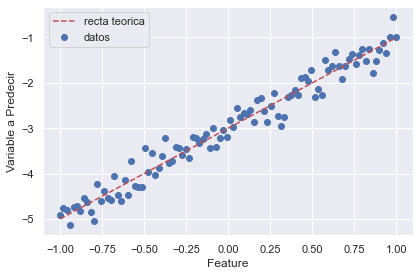

In [3]:
plt.scatter(x,y, label = 'datos')
plt.plot(x, m_0*x + b_0, '--', c = 'r', label = 'recta teorica')
plt.ylabel('Variable a Predecir')
plt.xlabel('Feature')
plt.legend()
plt.tight_layout()
if False:
    plt.savefig('Datos_ajuste_.png', dpi= 400)
plt.show()

En general, uno tiene ciertos datos y de esos datos quiere estimar los valores del modelo, en este caso, la pendiente y ordenada al origen de la recta. La hipótesis que vamos a utilizar es que la recta que mejor aproxime los datos va a ser la recta teórica que "genera" los datos.

Pero para definir la recta que "mejor aproxime" tenemos que cuantificar que es, precisamente, aproximar bien. Para ello usamos una métrica. En este caso vamos a usar MSE, pero también podría ser RMSE (equivalente a MSE) o MAE (cambia un poco la recta obtenida).

In [4]:
def MSE(y,y_pred):
    '''Calcula Mean Squared Error'''
    assert(len(y) == len(y_pred))
    n = len(y)
    return ((y - y_pred)**2).sum()/n

def RMSE(y,y_pred):
    '''Calcula Root Mean Squared Error'''
    assert(len(y) == len(y_pred))
    cost = MSE(y,y_pred)
    return np.sqrt(cost)

def MAE(y,y_pred):
    '''Calcula Mean Absolut Error'''
    assert(len(y) == len(y_pred))
    n = len(y)
    return (np.abs(y - y_pred)).sum()/n

#### **Un parametro libre**

Supongamos que conocemos la ordenada al origen $b$, y solamente tenemos que obtener la pendiente $m$. Lo que podemos hacer entonces es *barrer* distintos valores para $m$ y ver a cuál corresponde el mínimo del costo. **Importante**: en este caso, la función de costo depende de un único parámetro, $m$.

In [5]:
%%time
m_s = np.linspace(-5,5,1000)
b = -3
costos = []
for m in m_s:
    y_pred = m*x + b
    costos.append(MSE(y,y_pred))

costos = np.array(costos)

Wall time: 17 ms


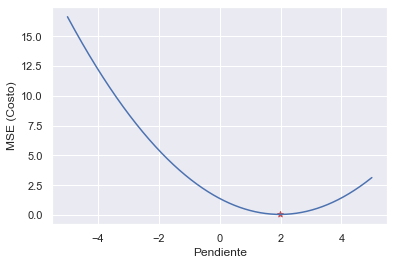

In [6]:
indice_minimo = np.argmin(costos)

plt.plot(m_s, costos)
plt.scatter(m_s[indice_minimo], costos[indice_minimo], marker = '*', c = 'r')
plt.xlabel('Pendiente')
plt.ylabel('MSE (Costo)')
plt.show()

#### **Dos parámetros libres**

Antes de continuar, piensa qué modificarían en el caso de tener que encontrar no uno sino dos parámetros libres. Es decir, $m$ y $b$. En este caso, ¿de cuántos parámetros depende la función de costo?¿Cómo será su visualización?

In [7]:
m_s = np.linspace(-5,5,500)
b_s = np.linspace(-5,0,500)

In [8]:
%%time
costos = []
for m in m_s:
    for b in b_s:
        y_pred = m*x + b
        costos.append(MSE(y,y_pred))
costos = np.array(costos)

Wall time: 2.31 s


**Visualización**

In [9]:
Ms, Bs = np.meshgrid(m_s,b_s, indexing = 'ij')
costos_matriz = costos.reshape(m_s.size, b_s.size)

C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


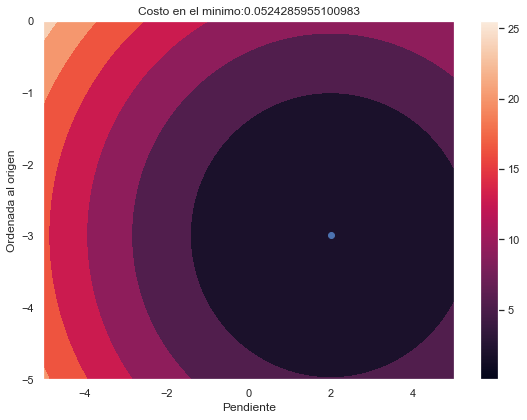

In [10]:
idxs_minimo = np.unravel_index(costos_matriz.argmin(), costos_matriz.shape)
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,costos_matriz)
ax.contourf(Ms, Bs, costos_matriz)
plt.colorbar()
plt.scatter(Ms[idxs_minimo], Bs[idxs_minimo])
plt.title('Costo en el minimo:' + str(costos_matriz[idxs_minimo]))
plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

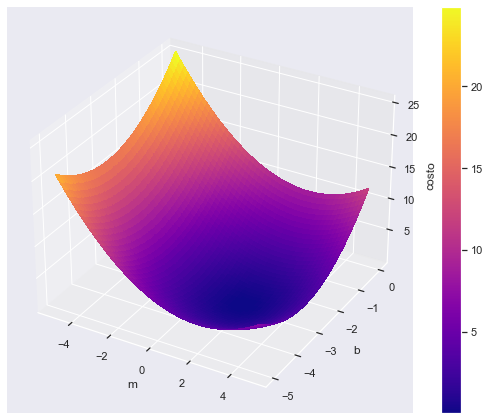

In [16]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Ms, Bs,costos_matriz,linewidth=0.0, antialiased=False, cmap = 'plasma')
# ax.view_init(0, 180)
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('costo')
plt.tight_layout()
plt.colorbar(surf)    
# plt.savefig('costo_3d.png', dpi = 400)
plt.show()

Graficamos la recta que encontramos y la comparamos con la distribución de datos y la recta teórica.

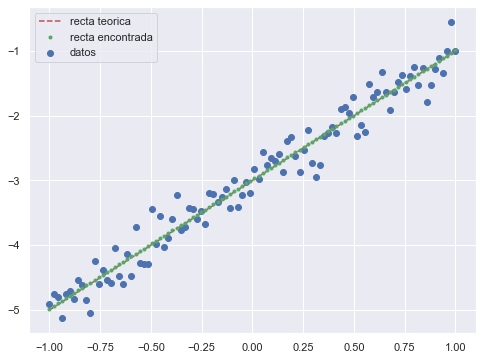

In [17]:
m_encontrado = Ms[idxs_minimo]
b_encontrado = Bs[idxs_minimo]

plt.figure(figsize = (8,6))
plt.scatter(x,y, label = 'datos')
plt.plot(x, m_0*x + b_0, '--', c = 'r', label = 'recta teorica')
plt.plot(x, m_encontrado*x +b_encontrado, '.', c = 'g', label = 'recta encontrada')
plt.legend()
plt.show()

### 1.2 Descenso por gradiente

**Nota**: Para los que nunca hayan visto análisis matemático, no importa si no entienden lo que sigue. La idea que les tiene que quedar es que podemos obtener la dirección en la cual movernos para llegar al mínimo de la función de costo.


Para hacer descenso por gradiente necesitamos las derivadas. Notar que la función de costo es función de la pendiente $m$ y la ordenada al origen $b$. Para simplificar, vamos a asumir que después de hacer varios reemplazos y algunas cuentas, la función de costo tiene la siguiente forma:

$$MSE(m, b) = (m-2)^2 + (b+3)^2$$

¿Están de acuerdo que el mínimo se obtiene para $m = 2$ y $b = -3$? Si no estás de acuerdo, discutir con un/a compañero/a hasta que lo estés.

Escribimos la función MSE, sus derivadas y el gradiente.


In [20]:
def MSE_m_y_b(m,b):
    return (m-2)**2 + (b+3)**2

def der_MSE_m(m,b):
    '''Derivada de MSE respecto a m'''
    return 2*(m-2)

def der_MSE_b(m,b):
    '''Derivada de MSE respecto a b'''
    return 2*(b+3)

def gradiente(m,b):
    gradiente = np.array([der_MSE_m(m,b), der_MSE_b(m,b)])
    return gradiente

Elegimos un valor al azar para $m$ y otro para $b$ y calculamos el gradiente.

In [21]:
m_prueba = -1 #Solo aca tienen que cambiar
b_prueba = -2 #Solo aca tienen que cambiar

grad = gradiente(m_prueba, b_prueba)
print(grad)

### Esto es para que tenga norma 1. Ignorar
grad = grad/np.linalg.norm(grad)
print(grad)

[-6  2]
[-0.9486833   0.31622777]


Y ahora graficamos la función de costo con menos el gradiente obtenido para el punto elegido.

C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


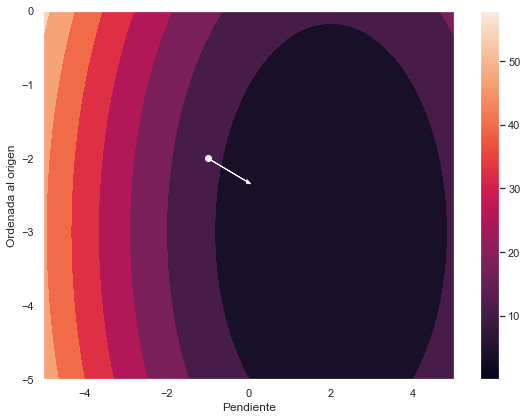

In [22]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,MSE_m_y_b(Ms, Bs))
ax.contourf(Ms, Bs, MSE_m_y_b(Ms, Bs))
plt.colorbar()

plt.scatter(m_prueba,b_prueba, c="white")

##Asegurate de entender bien que significan los parámetros: m_prueba,b_prueba, -grad[0] y -grad[1]. ¿Por qué el grad está en negativo?
plt.arrow(m_prueba,b_prueba, -grad[0], -grad[1], head_width=0.05, head_length=0.1, fc='white', ec='white')

plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

**Para probar:** Modifica los valores de `m_prueba` y `b_prueba` y convercerse de que el negativo del gradiente apunta hacia el mínimo. **Importante**: ¿Cuánto vale el gradiente en el mínimo?



**Descenso por gradiente**

Descenso por gradiente consiste entonces en ir haciendo sucesivos pasos, siguiendo la dirección que marca el negativo del gradiente, hasta llegar al mínimo o muy cerca de él. En general:

1. Empezamos con valores aleatorios de los parámetros.
2. Repetimos tantas veces como sea necesario
    1. Calculamos el gradiente (derivadas) de la función de costo respecto al valor actual de los parámetros.
    2. Actualizamos los valores de los parámetros siguiendo menos la derivada para cada uno.
    $$ m_{nuevo} = m_{viejo} - \alpha * \frac{dMSE(m,b)}{dm} $$
    $$ b_{nuevo} = b_{viejo} - \alpha * \frac{dMSE(m,b}{db} $$
      
      
Al **hiperparámetro** $\alpha$ se lo conoce como *learning rate* y lo van a encontrar en casi todos los frameworks donde se implemente descenso por gradiente. Es, sin duda, uno de los principales hiperparámetros en cualquier impolementación.

Lo implementamos. Definimos donde empezar, cuantos pasos hacer y el *learning rate*.

# probamos... 

[ 0. -1.]
[ 0. -1.]


C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


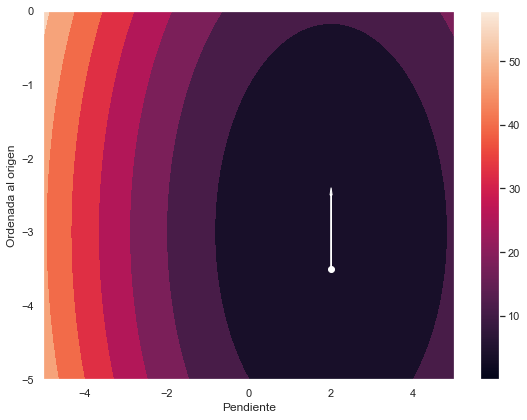

In [31]:

m_prueba = 2 #Solo aca tienen que cambiar
b_prueba = -3.5 #Solo aca tienen que cambiar

grad = gradiente(m_prueba, b_prueba)
print(grad)

### Esto es para que tenga norma 1. Ignorar
grad = grad/np.linalg.norm(grad)
print(grad)

fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,MSE_m_y_b(Ms, Bs))
ax.contourf(Ms, Bs, MSE_m_y_b(Ms, Bs))
plt.colorbar()

plt.scatter(m_prueba,b_prueba, c="white")

##Asegurate de entender bien que significan los parámetros: m_prueba,b_prueba, -grad[0] y -grad[1]. ¿Por qué el grad está en negativo?
plt.arrow(m_prueba,b_prueba, -grad[0], -grad[1], head_width=0.05, head_length=0.1, fc='white', ec='white')

plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

In [32]:
m = -1   #por ahora, los elegimos a mano, pero deberia ser al azar
b = -1   #por ahora, los elegimos a mano, pero deberia ser al azar

max_steps = 50 # Modificar despues
alpha = 0.1

Ejecutamos descenso por gradiente la cantidad de pasos que sea necesario.

In [33]:
costos = []
m_obtenidos = []
b_obtenidos = []

for step in range(max_steps):
    costos.append(MSE_m_y_b(m,b))
    m_obtenidos.append(m)
    b_obtenidos.append(b)
    m = m - alpha*der_MSE_m(m,b)
    b = b - alpha*der_MSE_b(m,b)

# Agregamos el ultimo paso que no lo hicimos
costos.append(MSE_m_y_b(m,b))
m_obtenidos.append(m)
b_obtenidos.append(b)

# Llevamos a arreglos
costos = np.array(costos)
m_obtenidos = np.array(m_obtenidos)
b_obtenidos = np.array(b_obtenidos)

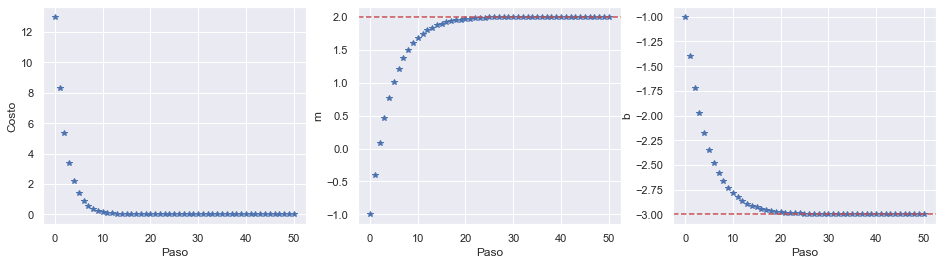

In [34]:
plt.figure(figsize = (16,4))

plt.subplot(1,3,1)
plt.plot(costos, '*')
plt.xlabel('Paso')
plt.ylabel('Costo')

plt.subplot(1,3,2)
plt.plot(m_obtenidos, '*')
plt.axhline(m_0, linestyle = '--', c = 'r', label = 'm real')
plt.xlabel('Paso')
plt.ylabel('m')

plt.subplot(1,3,3)
plt.plot(b_obtenidos, '*')
plt.axhline(b_0,  linestyle = '--', c = 'r', label = 'b real')
plt.xlabel('Paso')
plt.ylabel('b')

plt.show()

C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


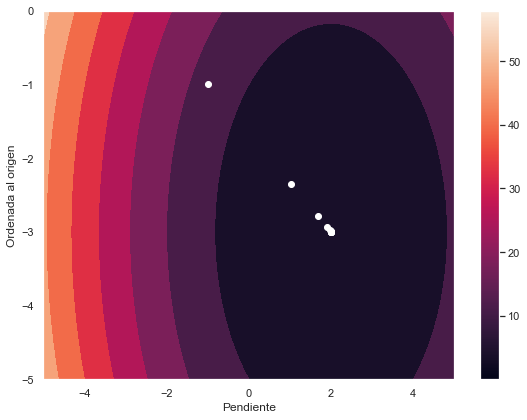

In [35]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,MSE_m_y_b(Ms, Bs))
ax.contourf(Ms, Bs, MSE_m_y_b(Ms, Bs))
plt.colorbar()
plt.scatter(m_obtenidos[::5],b_obtenidos[::5], c="white") #notar que grafica cada 5 pasos
plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

### ¿Anda siempre?

In [36]:
x = np.linspace(-1,1,500)
y = np.sin(10*x)

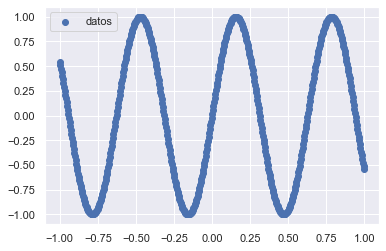

In [37]:
plt.scatter(x,y, label = 'datos')
plt.legend()
plt.show()

In [38]:
w_s = np.linspace(0,50,1000)
costos = []
for w in w_s:
    y_pred = np.sin(w*x)
    costos.append(MSE(y,y_pred))
costos = np.array(costos)

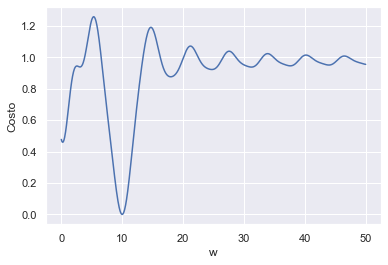

In [39]:
plt.plot(w_s, costos)
plt.xlabel('w')
plt.ylabel('Costo')
plt.show()

Notar que hay muchos *mínimos locales* y un *mínimo absoluto*. En más dimensiones, es fácil confundir un mínimo local con el mínimo que estamos buscando.

**Variantes de descenso por el gradiente (para acelerar/mejorar la convergencia)**:
1. Stochastic gradient descent (SGD)
2. Minibatches
3. Agregar un término para dar inercia a la búsqueda, tratando de pasar por alto mínimos locales.

## 2. Regresión logística

En Scikit-Learn, la regresión logística se implementa como cualquier otro modelo de clasificación. Veamos dos ejemplos, uno 1D y otro 2D. Para simplificar la exposición, no vamos a hacer un `train_test_split`, pero esto no significa que no haya que hacerlo.

### 2.1 Un Atributo

In [41]:
def sigmoid_function(x,w0, w1):
    '''Equivalente a perceptron con funcion de activacion sigmoide'''    
    z = w0 + w1*x #notar que es una funcion lineal
    y = 1/(1 + np.exp(-z))   #notar que es una composicion
    return y

Empecemos generando datos: 1 atributos, dos clases.

In [42]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=1,
                  random_state=1, cluster_std= 1.5)

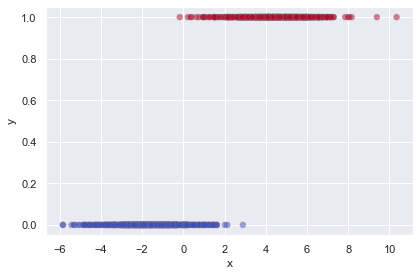

In [43]:
plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

Como siempre, es muy importante leer la documentación del clasificador. En este caso, `LogisticRegression`.

In [44]:
clf = LogisticRegression().fit(X,y)

In [45]:
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.974

Veamos los parámetros obtenidos:

In [46]:
print(clf.coef_, clf.intercept_)

[[2.44855129]] [-3.39207913]


Con estos parámetros, podemos graficar la curva obtenida por la regresión logística. Ojo, ésta NO es la frontera de decisión. Usamos la función que definimos más arriba, `sigmoid_function`.

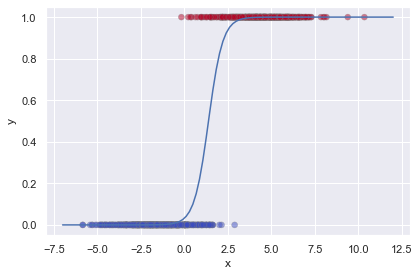

In [47]:
plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)

x_plot = np.linspace(-7,12,100)
plt.plot(x_plot, sigmoid_function(x_plot,clf.intercept_[0], clf.coef_[0][0]))

plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

Otra forma de obtener esa curva habría sido usando el método `predict_proba` del clasificador:

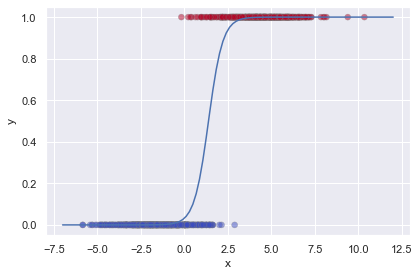

In [48]:
plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)

x_plot = np.linspace(-7,12,100)
y_plot = clf.predict_proba(x_plot.reshape(-1,1))[:,1]
plt.plot(x_plot, y_plot)

plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

### 2.2 Dos atributos

La extensión al caso con dos atributos es prácticamente igual. La única diferencia es que las herramientas para visualizar son un poco más complejas.

In [57]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2,
                  random_state=1, cluster_std= 2.0)

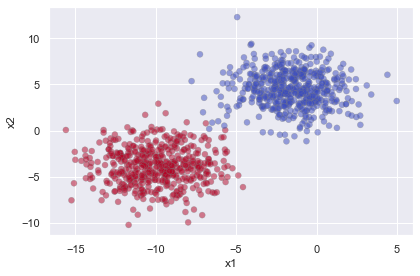

In [58]:
plt.scatter(X[:,0], X[:,1], c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()
plt.show()

Entrenamos y calculamos error:

In [59]:
clf = LogisticRegression().fit(X,y)
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.998

Y, ahora sí, **graficamos los puntos junto con la frontera obtenida**.

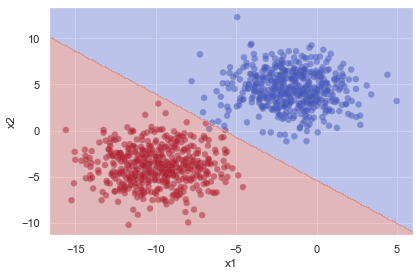

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap =cm.coolwarm)

plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()
plt.savefig('RL_2D_2.png', dpi = 300)
plt.show()

Si graficar la probabilidad

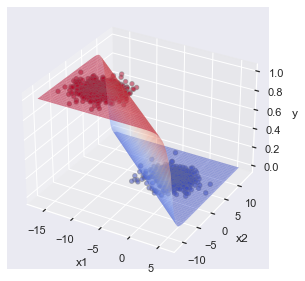

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1],y, c = y,alpha = 0.5, lw = 1, edgecolors= 'grey', cmap=cm.coolwarm)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = (clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]).reshape(xx.shape)


surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm,
                   linewidth=0, antialiased=True, alpha = 0.5)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.tight_layout()
# plt.savefig('RL_2D_3.png', dpi = 300)

plt.show()

### 2.3 Ejercitación

Si no conoces la historia del Challenger, puedes leerla [aquí](https://es.wikipedia.org/wiki/Transbordador_espacial_Challenger).

El objetivo es entrenar una regresión logística sobre los datos obtenido y decidir si el día del despegue del Challenger había información que sugiriera que podía haber un accidente.

Nosotros nos encargamos del preprocesamiento y de los gráficos. Tu te encargarás de entrenar el modelo.

In [73]:
dataset = pd.read_csv('../datasets/DS_Bitácora_24_Challenger.csv')
dataset.dropna(inplace = True) # Tiramos los NaN (una sola fila)
dataset['Temperature (C)'] = np.round((dataset['Temperature'] - 32)/1.8,2) # pasamos a celcius
dataset

,Date,Temperature,Damage Incident,Temperature (C)
0,04/12/1981,66,0,18.89
1,11/12/1981,70,1,21.11
2,3/22/82,69,0,20.56
4,01/11/1982,68,0,20.00
5,04/04/1983,67,0,19.44
6,6/18/83,72,0,22.22
7,8/30/83,73,0,22.78
8,11/28/83,70,0,21.11
9,02/03/1984,57,1,13.89
10,04/06/1984,63,1,17.22


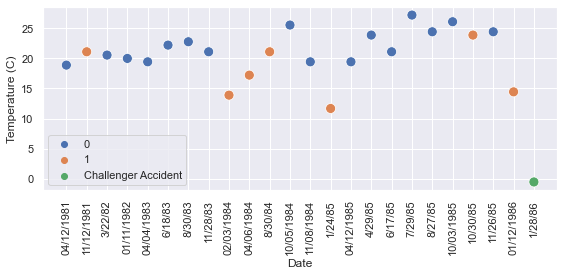

In [76]:
plt.figure(figsize = (8,4))
plot = sns.scatterplot(x = 'Date', y  = 'Temperature (C)', hue = dataset['Damage Incident'].tolist(), data = dataset, s = 100)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
# plt.savefig("challenger1.png", dpi = 300)
plt.show()

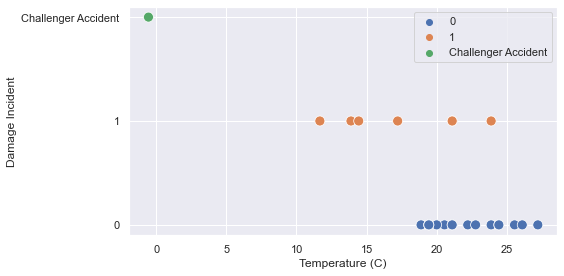

In [78]:
# dataset.drop([24], inplace = True)
plt.figure(figsize = (8,4))
plot = sns.scatterplot(x = 'Temperature (C)', y  = 'Damage Incident', hue = dataset['Damage Incident'].tolist(), data = dataset, s = 100)
plt.tight_layout()
# plt.savefig("challenger2.png", dpi = 300)
plt.show()

**Variables para entrenamiento**

In [79]:
X = dataset.drop([24])['Temperature (C)'].values.reshape(-1, 1)
y = dataset.drop([24])['Damage Incident'].values.astype(int)

Ahora sí, te dejamos solo/a. 

1. Entrena una regresión logística y calcula su desempeño. Puedes usar exactitud u otra métrica que consideres apropiada.
1. Grafica la probabilidad en función de la temperatura. 
1. ¿Qué predice tu clasificador para el caso del Challenger?

No te preocupes por hacer un `train_test_split`, este ejemplo es más bien demostrativo.

In [80]:
clf = LogisticRegression().fit(X,y)
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.8695652173913043

In [107]:
probabilidad = clf.predict_proba(X)
probabilidad[:,1]
df = pd.DataFrame()
df = pd.DataFrame(X, columns={'Temperatura'})
df['probabilidadAccidente'] = probabilidad[:,1]
df['Damage Incident'] = y
df

,Temperatura,probabilidadAccidente,Damage Incident
0,18.89,0.426246,0
1,21.11,0.232950,1
2,20.56,0.274859,0
3,20.00,0.322031,0
4,19.44,0.373132,0
5,22.22,0.162601,0
6,22.78,0.134162,0
7,21.11,0.232950,0
8,13.89,0.847814,1
9,17.22,0.592845,1


<AxesSubplot:xlabel='Temperatura', ylabel='probabilidadAccidente'>

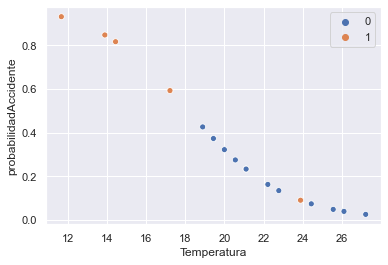

In [110]:

sns.scatterplot(data=df,x='Temperatura',y='probabilidadAccidente',hue=df['Damage Incident'].tolist())